This is a tutorial on how to use the Agent class in the Agent.py file. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import DeepRL_Agent

# First we make a simple data set.

In [2]:
agg = pd.read_csv("/Users/Joseph/Desktop/Data/Bear_SynDta.csv") #This is synthetic data generated using our order book.
agg[agg.columns[0]] = pd.to_datetime(agg[agg.columns[0]])
agg = agg.set_index(agg.columns[0])

Next we define some other features. VIB is the volume imbalance, QV is the expanding standard deviation of the price. QVAR is the quadratic variation of the price process. Order imblance is the average of the signed order flow. Pchange is the change in price since the beginning of the day. We aggregate the values over each day. Since we are selling, the price column is automatically the bid price. 

In [3]:
%%time
agg["VIB"] = ((agg["Ask Price"]*agg["Ask Size"] - agg["Bid Price"]*agg["Bid Size"])/(agg["Ask Size"] + agg["Bid Size"])).fillna(0)
agg["VIB"] = agg["VIB"]/1000
days = agg.index.strftime("%Y-%m-%d").unique()
vals = np.array((agg.loc[days[0]]["Price"][0]-agg.loc[days[0]]["Price"]).values)
QV = agg.loc[days[0]]["Price"].rolling(window = 5*60, min_periods = 0).std()
QVAR = np.append([0],np.diff(agg.loc[days[0]]["Price"].values)**2)
QVAR = np.cumsum(QVAR)
order_imbalance = agg.loc[days[0]]["Sign"].rolling(window = 5*60, min_periods = 0).mean()
for day in days[1:]:
    append_ = (agg.loc[day]["Price"][0]-agg.loc[day]["Price"]).values
    vals = np.append(vals,append_)
    QV = np.append(QV, agg.loc[day]["Price"].rolling(window = 5*60,min_periods= 0).std())
    QVAR_ = np.append([0],np.diff(agg.loc[day]["Price"].values)**2)
    QVAR_ = np.cumsum(QVAR_)
    QVAR = np.append(QVAR, QVAR_)
    order_imbalance = np.append(order_imbalance, agg.loc[day]["Sign"].rolling(window = 5*60, min_periods = 0).mean())
agg["Pchange"] = vals/100
agg["QV"] = QV
agg["QVAR"] = QVAR
agg["OI"] = order_imbalance
agg = agg.fillna(0)
keys_lob = {agg.columns[i]: i for i in range(agg.shape[1])}

CPU times: user 10.8 s, sys: 988 ms, total: 11.8 s
Wall time: 17.5 s


In [4]:
def subset_day(df):
    #Subsets the data as done in the paper.
    days = df.index.strftime("%Y-%m-%d").unique()

    episodes = []
    episodes.append(df[days[0]].values)
    for day in days[1:]:
        #print(day)
        episodes.append(df[day].values)

    episodes = np.array(episodes)

    return episodes
#Subset every half and hour between 10:00 am and 3:30 pm. 
#Could reaggregate all the data over the half an hour intervals. 

'''
Remove trades occuring before 10:00 am, aggregate by each day, and the split each episode into half an hour increments. 
'''
agg = agg[agg.index.strftime("%H") != "09"]
daily_episodes = subset_day(agg)
half_hour_eps = []
for ep in daily_episodes:
    for j in range(11):
        half_hour_eps.append(ep[60*30*j:60*30*(j+1)])

In [57]:
#Define our stuff.
train_eps = half_hour_eps[:75] #Only training on the first 20 episodes for speed, can increase. 
test_eps = half_hour_eps[100:125] #More like val eps. 
keys = keys_lob
alpha = 0.01
epsilon = 0.99
tau = 0.95
num_samps = 100
gamma = 0.99
init_inv = 12
rho = 15
length = 3
features = ["VIB"] #Can add more features too.

In [58]:
RL_agent = DeepRL_Agent.Agent()

In [59]:
#Initialize our specific model. 
num_inputs = 3 + len(features)
RL_agent.default_model(num_inputs)

  -0.04016167]
3 2 [ 1.          3.          3.         -0.01421154]
0 0 [ 3.         12.          0.         -0.03504167]
7 1 [ 2.         12.          7.         -0.03387577]
5 2 [1.e+00 5.e+00 5.e+00 5.e-05]
0 0 [ 3.        12.         0.        -0.0232975]
2 1 [ 2.         12.          2.          0.04298816]
10 2 [1.00000000e+00 1.00000000e+01 1.00000000e+01 8.90142857e-03]
2 0 [ 3.         12.          2.          0.02094333]
1 1 [2.00000000e+00 1.00000000e+01 1.00000000e+00 3.31710526e-03]
9 2 [ 1.000e+00  9.000e+00  9.000e+00 -4.099e-03]
6 0 [ 3.        12.         6.        -0.0185665]
2 1 [2.e+00 6.e+00 2.e+00 5.e-05]
4 2 [1.       4.       4.       0.005735]
7 0 [ 3.       12.        7.       -0.049338]
1 1 [ 2.          5.          1.         -0.04651206]
4 2 [ 1.          4.          4.         -0.00558136]
2 0 [ 3.        12.         2.         0.0306875]
2 1 [ 2.         10.          2.          0.01408885]
8 2 [1.e+00 8.e+00 8.e+00 5.e-06]
0 0 [3.000000e+00 1.200000e+01

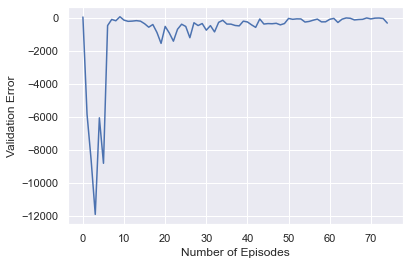

In [60]:
RL_agent.train(alpha, epsilon, tau, num_samps, gamma, init_inv, rho, length, features, 
    train_eps, test_eps, keys)

In [61]:
test_eps = half_hour_eps[125:]

000000e+00 9.00000000e+00 4.30684211e-03]
6 0 [ 3.       12.        6.       -0.016477]
0 1 [ 2.00000000e+00  6.00000000e+00  0.00000000e+00 -1.84666667e-03]
6 2 [ 1.          6.          6.         -0.00741045]
3 0 [ 3.00e+00  1.20e+01  3.00e+00 -5.05e-03]
4 1 [ 2.          9.          4.         -0.01219067]
5 2 [ 1.00000000e+00  5.00000000e+00  5.00000000e+00 -1.68633333e-03]
1 0 [3.00000000e+00 1.20000000e+01 1.00000000e+00 3.05555556e-03]
2 1 [2.000e+00 1.100e+01 2.000e+00 7.916e-03]
9 2 [ 1.00000000e+00  9.00000000e+00  9.00000000e+00 -5.85076923e-03]
1 0 [3.00000000e+00 1.20000000e+01 1.00000000e+00 2.12541667e-03]
3 1 [ 2.0e+00  1.1e+01  3.0e+00 -5.8e-03]
8 2 [1.0000e+00 8.0000e+00 8.0000e+00 4.4125e-03]
0 0 [3.00000000e+00 1.20000000e+01 0.00000000e+00 4.65147059e-03]
12 1 [2.00000000e+00 1.20000000e+01 1.20000000e+01 1.99884615e-03]
0 2 [ 1.      0.      0.     -0.0088]
2 0 [ 3.         12.          2.          0.01434615]
2 1 [2.00000000e+00 1.00000000e+01 2.00000000e+00 1.4

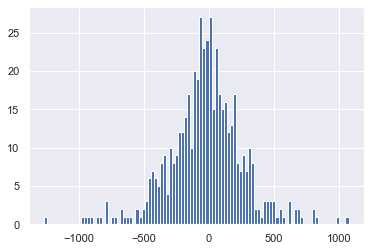

In [62]:
RL_agent.Performance_Evaluation(init_inv, test_eps, alpha, length, features, keys, RL_agent.Main_Model)

Future directions to update:

1. Getting more computing power to do more definitive tests. 
2. One model per ticker or one model for all tickers?
3. Many order book models rely on Bayesian dynamics, potentially try and leverage some algorithms in Bayesian RL.
4. Combine the agent with a prediction model of the short term price dynamics and train both the agent and the predictive model in an online fashion. 

In [ ]:
print(len(half_hour_eps))

In [64]:
Q = RL_agent.Main_Model

In [37]:
Q.predict(np.array([1,1,1,1,1]).reshape((1,-1)))[0,0]

array([[14.488665]], dtype=float32)

In [93]:
vals = pd.DataFrame(np.zeros((11,50)), columns = np.round(np.linspace(-1,1,50),1), index =  np.round(np.linspace(0,1,11),1))
for i in vals.index:
    for j in vals.columns:
        vals.loc[i][j] = Q.predict(np.array([1,1,i,j]).reshape((1,-1)))[0,0]

Text(30.5, 0.5, 'Action')

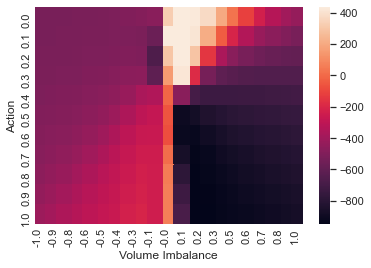

In [94]:
ax = sns.heatmap(vals)
ax.tick_params(axis='both', which='both', length=0)
ax.set_xlabel("Volume Imbalance")
ax.set_ylabel("Action")